# Traffic forecasting using LSTM

**Author:** Carnot Braun & Allan M.Sousa
**Date created:** 2024/05/08<br>
**Last modified:** 2024/05/08<br>
**Description:** This example demonstrates how to do timeseries forecasting over graphs.

## Setup

In [6]:
import pandas as pd
import numpy as np
import os
import typing
import matplotlib.pyplot as plt
import scipy
import time 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
import seaborn as sns

## Agregar as emissões por RSU, criando uma serie temporal para cada

For the LuST Dataset

In [2]:
## Função para carregar e agregar dados de cada RSU
def load_and_aggregate_data(folder_path):
    rsu_data = {}
    
    for filename in os.listdir(folder_path):
        if filename.endswith('.csv'):
            file_path = os.path.join(folder_path, filename)
            road = os.path.splitext(filename)[0]
            a = pd.read_csv(file_path, sep=',', header=None, usecols=[0, 1, 3], 
                            names=['step', 'road_id', 'c02_emission'], skiprows=[0])
            # Converte o tempo para datetime e agrupa por 1 segundo
            a['step'] = pd.to_datetime(a['step'], unit='s')
            a = a.groupby([pd.Grouper(key='step', freq='1s')]).sum().reset_index()
            a['road_id'] = road

            if road in rsu_data:
                rsu_data[road] = pd.concat([rsu_data[road], a], axis=0)
            else:
                rsu_data[road] = a
                
    return rsu_data

folder_path = '/Users/carnotbraun/mestrado/simu/data/rsus_lust_csv/'
rsu_data = load_and_aggregate_data(folder_path)


USE THIS ONE, WHEN ITS NOT THE LUST DATASET

In [81]:
def load_and_aggregate_data(folder_path):
    rsu_data = {}
    
    for filename in os.listdir(folder_path):
        if filename.endswith('.csv'):
            file_path = os.path.join(folder_path, filename)
            road = os.path.splitext(filename)[0]
            a = pd.read_csv(file_path, sep=',', header=None, usecols=[0, 1, 3], 
                            names=['step', 'road_id', 'c02_emission'], skiprows=[0])
            
            # Converte o tempo para datetime
            a['step'] = pd.to_datetime(a['step'], unit='s')
            
            # Converte c02_emission para numérico, forçando erros a NaN e preenchendo NaN com 0
            a['c02_emission'] = pd.to_numeric(a['c02_emission'], errors='coerce').fillna(0)
            
            # Agrupa por 1 segundo, somando apenas colunas numéricas
            a = a.groupby([pd.Grouper(key='step', freq='1s')])[['c02_emission']].sum().reset_index()
            a['road_id'] = road

            if road in rsu_data:
                rsu_data[road] = pd.concat([rsu_data[road], a], axis=0)
            else:
                rsu_data[road] = a
                
    return rsu_data

folder_path = '/Users/carnotbraun/mestrado/simu/data/rsus_cologne_csv/'
rsu_data = load_and_aggregate_data(folder_path)


/var/folders/sm/wks1nk410cqg8yr78yrtlrw80000gn/T/ipykernel_1541/205527855.py:8: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  a = pd.read_csv(file_path, sep=',', header=None, usecols=[0, 1, 3],
/var/folders/sm/wks1nk410cqg8yr78yrtlrw80000gn/T/ipykernel_1541/205527855.py:8: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  a = pd.read_csv(file_path, sep=',', header=None, usecols=[0, 1, 3],


## Pré-processamento dos dados

In [3]:
def create_time_series(data_dict, time_col, value_col):
    time_series_data = {}
    
    for rsu, df in data_dict.items():
        df = df.sort_values(by=time_col)
        df[value_col] = df[value_col].rolling(5).mean()
        df.dropna(inplace=True)
        time_series_data[rsu] = df[[time_col, value_col]].set_index(time_col)
        
    return time_series_data

time_series_data = create_time_series(rsu_data, 'step', 'c02_emission')

## Visualizar séries temporais


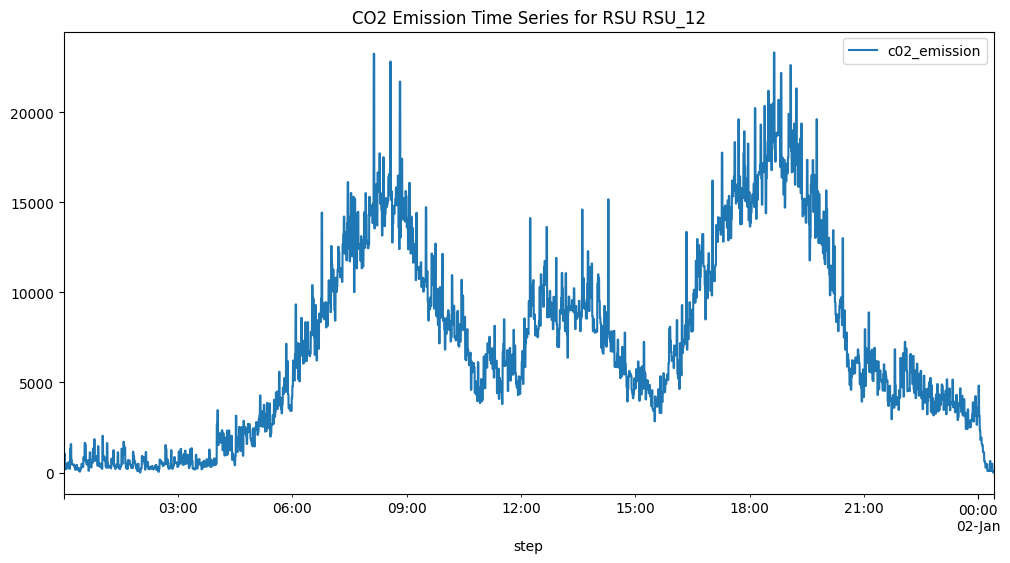

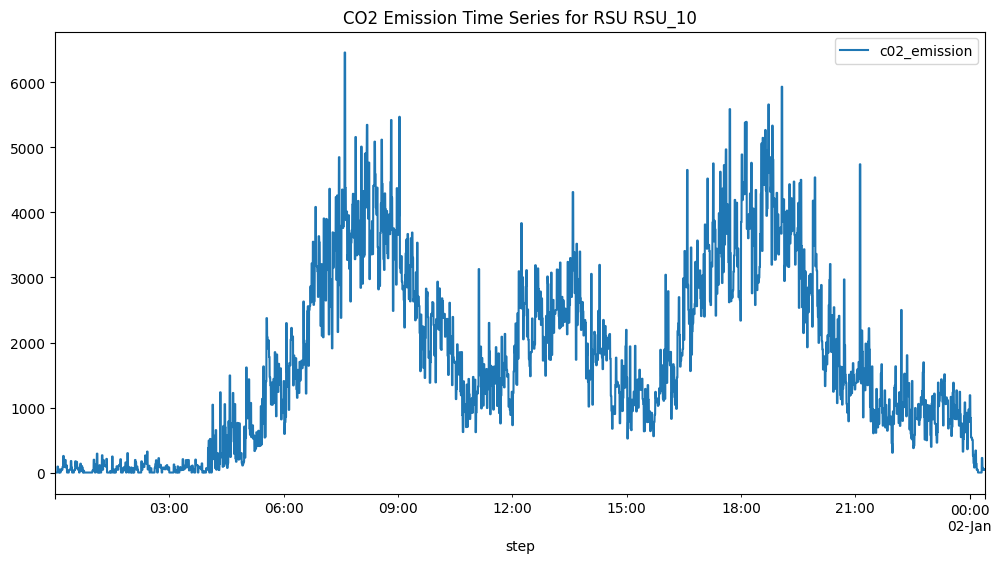

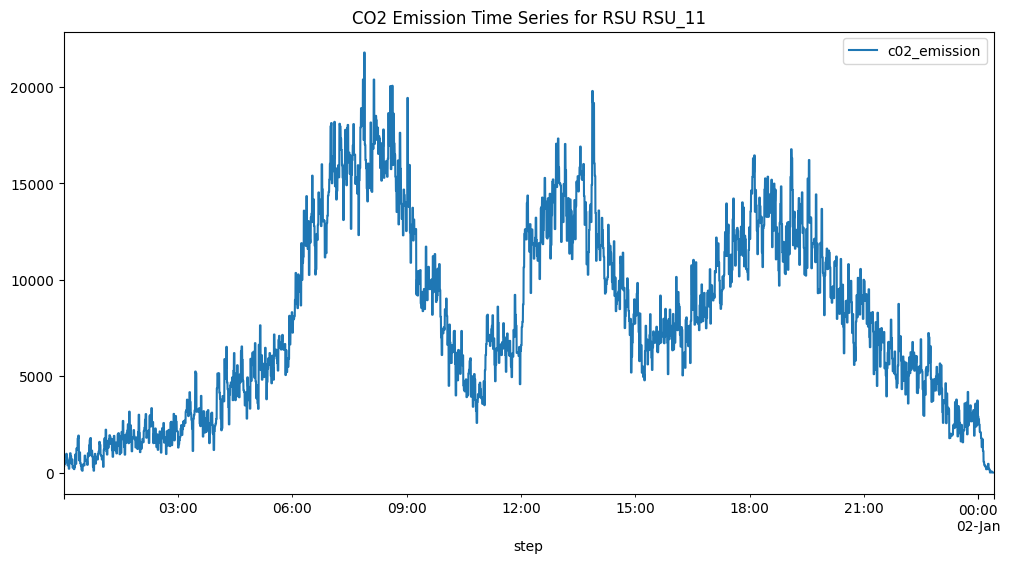

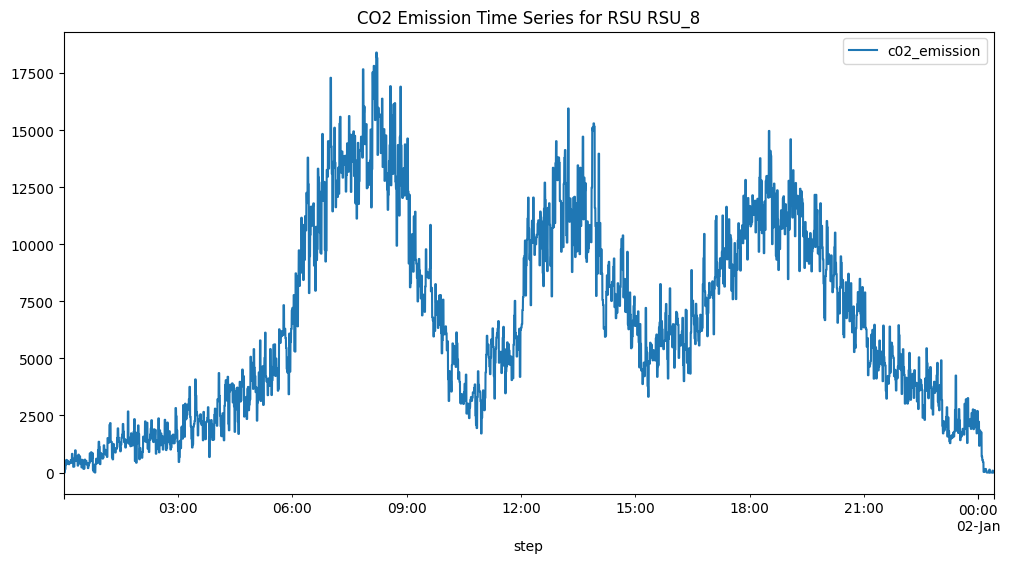

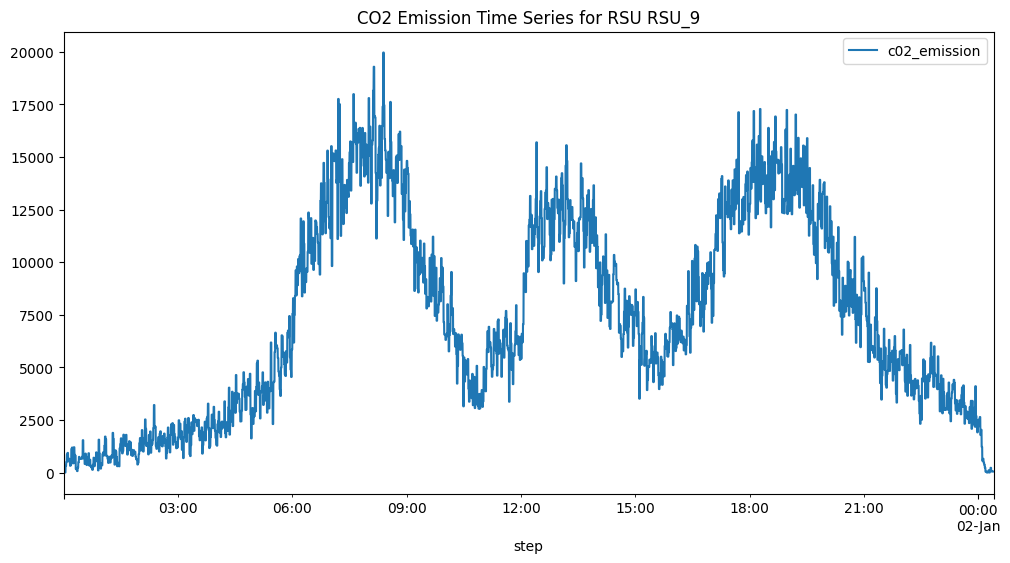

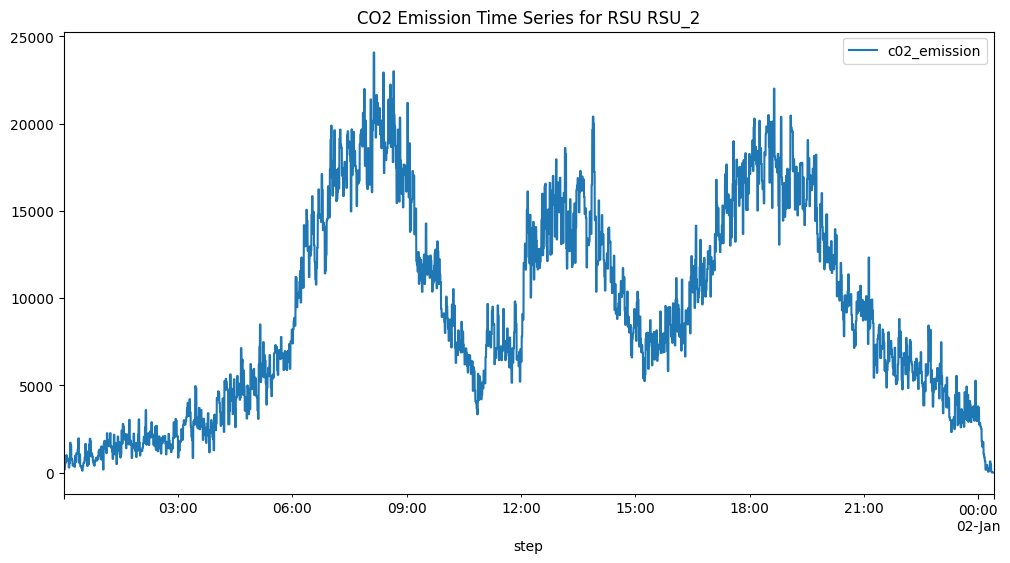

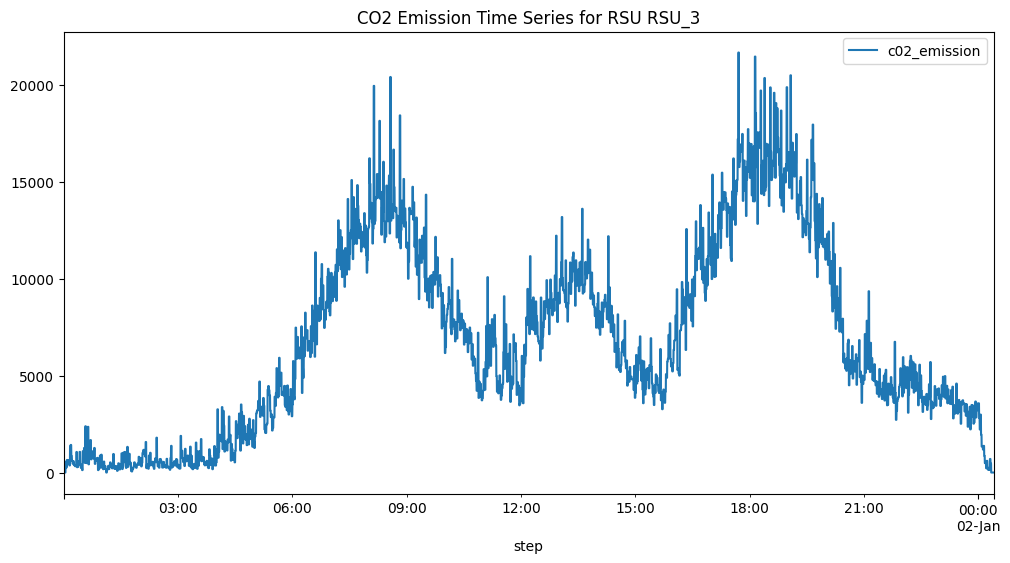

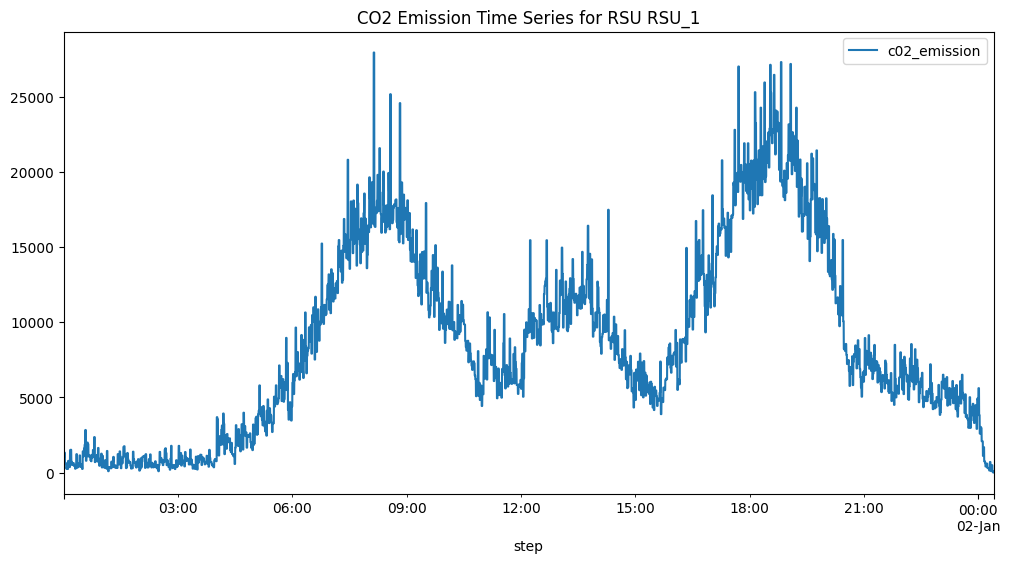

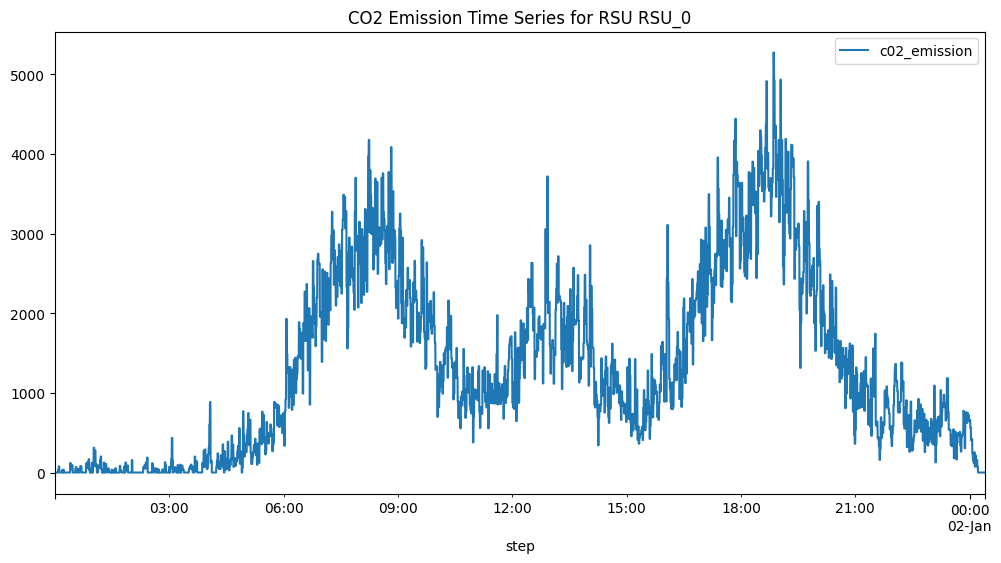

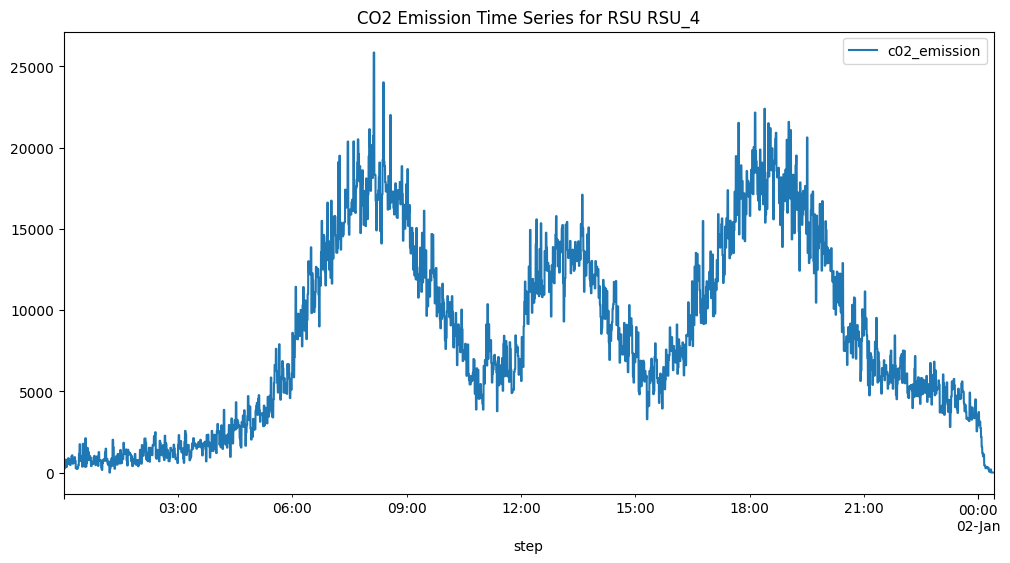

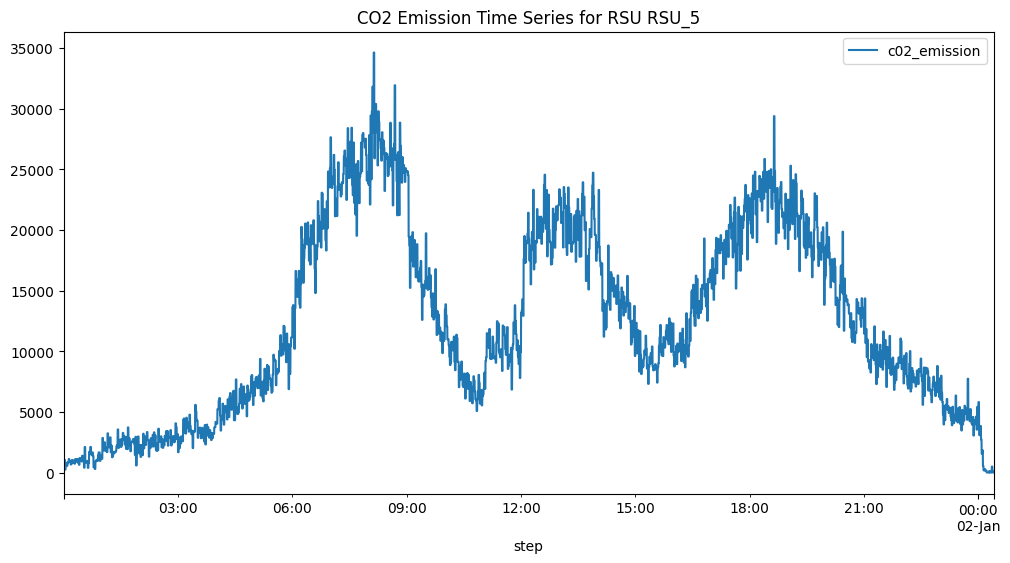

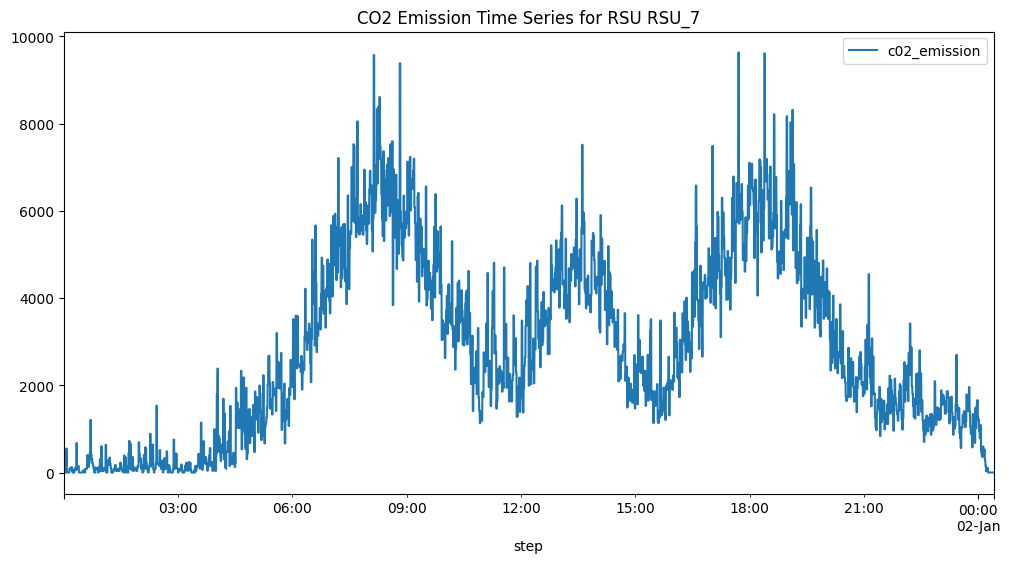

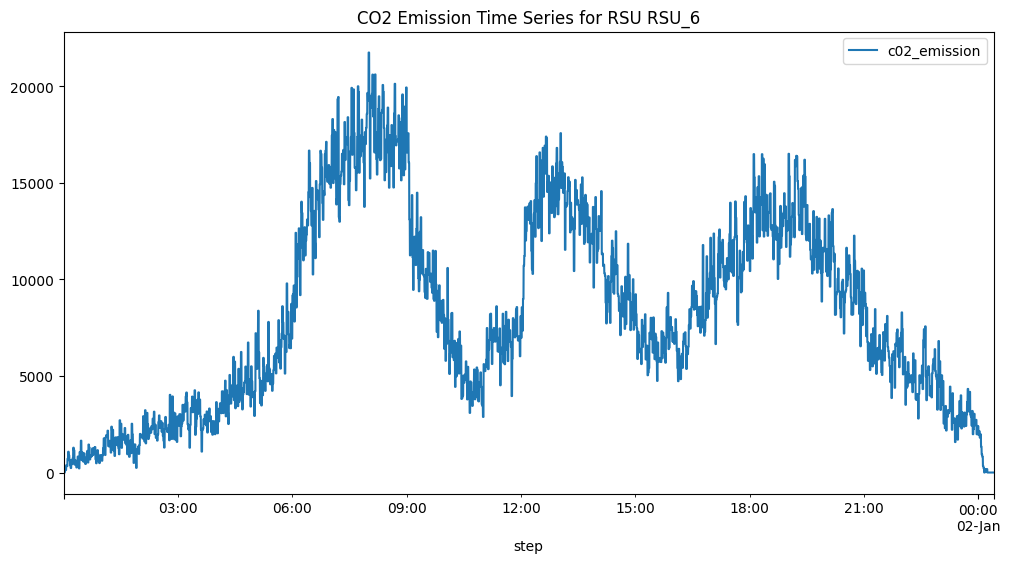

In [4]:
for rsu, ts in time_series_data.items():
    ts = ts.rolling(60).mean()
    ts.plot(title=f'CO2 Emission Time Series for RSU {rsu}', figsize=(12, 6))
    plt.show()

## Treinamento da LSTM

In [65]:
## Preparar dados para LSTM
def prepare_lstm_data(series, n_steps):
    X, y = [], []
    horizon = 5
    series = pd.Series(series).rolling(60).mean()
    series.dropna(inplace=True)
    series = series.values
    
    for i in range(len(series)):
        end_ix = i + n_steps
        if end_ix + horizon > len(series)-1:
            break
        seq_x, seq_y = series[i:end_ix], series[end_ix + horizon]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

n_steps = 10
scaler = MinMaxScaler()

lstm_data = {}
for rsu, ts in time_series_data.items():
    series = scaler.fit_transform(ts.values).flatten()
    X, y = prepare_lstm_data(series, n_steps)
    lstm_data[rsu] = (X, y)

# Dividir em treino e teste
train_data = {}
test_data = {}
for rsu, (X, y) in lstm_data.items():
    split_index = int(len(X) * 0.65)# 65% para treino, visto a quantidade de dados.
    train_data[rsu] = (X[:split_index], y[:split_index])
    test_data[rsu] = (X[split_index:], y[split_index:])

# Criar modelo LSTM para prever emissão de CO2
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=input_shape))
    model.add(LSTM(50, activation='relu', input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model


## Treinamento

In [66]:
errors = [] # Armazenar os erros de cada RSU
times = [] # Armazenar o tempo de execução de cada RSU

# Treinar e avaliar um modelo para cada RSU
for rsu, (X_train, y_train) in train_data.items():
    start_time = time.process_time()
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    model = create_lstm_model((X_train.shape[1], 1))
    
    model.fit(X_train, y_train, epochs=50, verbose=0)
    
    # Avaliar o modelo
    X_test, y_test = test_data[rsu]
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    y_pred = model.predict(X_test, verbose=0)
    
    mse = np.mean((y_test - y_pred.flatten())**2)
    print(f"RSU {rsu} - Mean Squared Error: {mse}")
    errors.append((rsu, mse))
    end_time = time.process_time()
    times.append((rsu, end_time - start_time))
    print(f"RSU {rsu} - Execution Time: {end_time - start_time} seconds")


/Users/carnotbraun/mestrado/learning_framework/frameworks/ecopredict/centralized/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/carnotbraun/mestrado/learning_framework/frameworks/ecopredict/centralized/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


RSU RSU_12 - Mean Squared Error: 2.2787429270475934e-06
RSU RSU_12 - Execution Time: 207.51123899999948 seconds
RSU RSU_10 - Mean Squared Error: 4.715739471921734e-06
RSU RSU_10 - Execution Time: 191.35066200000074 seconds
RSU RSU_11 - Mean Squared Error: 1.5392718111433389e-06
RSU RSU_11 - Execution Time: 192.0754859999979 seconds
RSU RSU_8 - Mean Squared Error: 1.575189578066809e-06
RSU RSU_8 - Execution Time: 190.13024700000096 seconds
RSU RSU_9 - Mean Squared Error: 2.1748513648054422e-06
RSU RSU_9 - Execution Time: 192.0559080000021 seconds
RSU RSU_2 - Mean Squared Error: 1.5256522390917266e-06
RSU RSU_2 - Execution Time: 191.35558400000082 seconds
RSU RSU_3 - Mean Squared Error: 2.5218715659001517e-06
RSU RSU_3 - Execution Time: 193.0136080000011 seconds
RSU RSU_1 - Mean Squared Error: 2.374568700489995e-06
RSU RSU_1 - Execution Time: 194.44794600000023 seconds
RSU RSU_0 - Mean Squared Error: 3.4759095993549888e-06
RSU RSU_0 - Execution Time: 192.71358200000032 seconds
RSU RSU_4 

In [67]:
times = pd.DataFrame(times, columns=['rsu', 'time'])
times.to_csv('time_h5.csv', index=False)

In [68]:
times

,rsu,time
0,RSU_12,207.511239
1,RSU_10,191.350662
2,RSU_11,192.075486
3,RSU_8,190.130247
4,RSU_9,192.055908
5,RSU_2,191.355584
6,RSU_3,193.013608
7,RSU_1,194.447946
8,RSU_0,192.713582
9,RSU_4,190.465393


In [69]:
errors = pd.DataFrame(errors, columns=['RSU', 'MSE'])
errors.to_csv('lstm_errors_h5.csv', index=False)

## Visualização

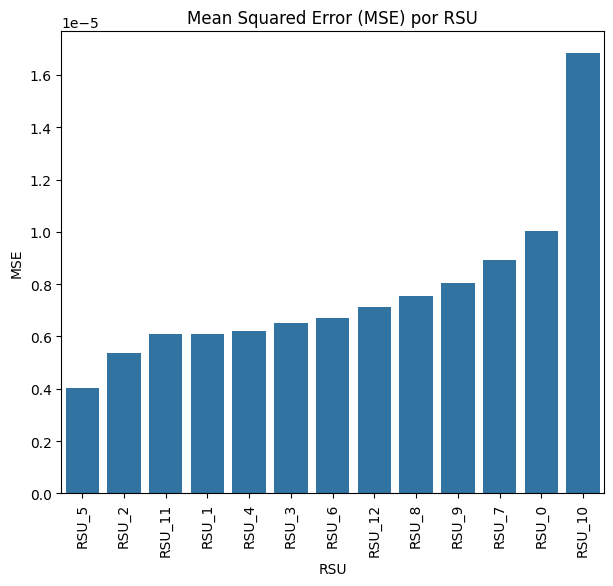

In [94]:
# Crie uma visualização do modelo LSTM para uma RSU

## Visualizar a eficiência do modelo
# Convertendo a lista de erros em DataFrame
errors_df = pd.DataFrame(errors, columns=['RSU', 'MSE'])
#quero ordenar as barras pela ordem crescente do erro
errors_df = errors_df.sort_values(by='MSE', ascending=True)
# Plotando os erros
#quero plotar apenas os 10 ultimos
#errors_df = errors_df.tail(10)
plt.figure(figsize=(7, 6))
sns.barplot(x='RSU', y='MSE', data=errors_df)
plt.xticks(rotation=90)
plt.title('Mean Squared Error (MSE) por RSU')
plt.xlabel('RSU')
plt.ylabel('MSE')
plt.show()


In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Inicializa a lista para armazenar as perdas (losses) para cada RSU em cada ponto no tempo
losses = []

# Calcula a perda para cada RSU em cada ponto no tempo
for rsu, (X_test, y_test) in test_data.items():
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    y_pred = model.predict(X_test, verbose=0).flatten()
    
    rsu_losses = np.square(y_pred - y_test)  # Calcula a loss (MSE) para cada ponto no tempo
    losses.append(rsu_losses)

# Converte a lista de perdas (losses) em um DataFrame
losses_df = pd.DataFrame(losses)

# Define os índices do DataFrame para representarem as RSUs
losses_df.index = [f'RSU {i+1}' for i in range(len(losses))]

# Transformar a coluna de tempo
time_intervals = pd.date_range(start='00:00', periods=losses_df.shape[1], freq='600S')
time_intervals = time_intervals.strftime('%H:%M')

# Cria um DataFrame temporário para armazenar os valores e garantir que os horários sejam únicos
temp_df = pd.DataFrame(losses_df.T)
temp_df['time'] = time_intervals
temp_df = temp_df.groupby('time').mean()

# Transforma de volta para o formato desejado
losses_df = temp_df.T

# Plota o heatmap
plt.figure(figsize=(18, 8))
ax = sns.heatmap(losses_df, cmap="YlGnBu", cbar_kws={'label': 'Loss (MSE)'})
ax.set_xlabel('Horário do Dia')
ax.set_ylabel('RSU')
plt.title('Heatmap de Loss (MSE) por RSU e Tempo')
plt.xticks(rotation=90)  # Rotaciona os rótulos do eixo x para melhor legibilidade
plt.savefig('co2_heatmap_h25.png', dpi=300, bbox_inches='tight')
plt.show()


/var/folders/sm/wks1nk410cqg8yr78yrtlrw80000gn/T/ipykernel_15412/3757596047.py:24: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  time_intervals = pd.date_range(start='00:00', periods=losses_df.shape[1], freq='600S')
/var/folders/sm/wks1nk410cqg8yr78yrtlrw80000gn/T/ipykernel_15412/3757596047.py:31: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  temp_df = temp_df.set_index('time').resample('2H').mean()


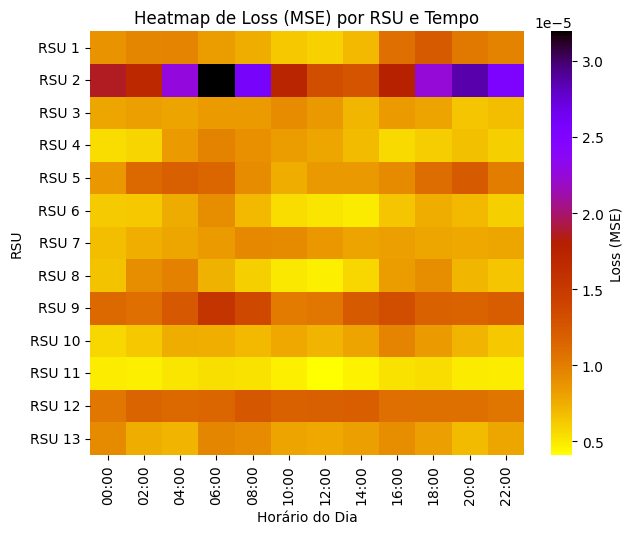

In [229]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Inicializa a lista para armazenar as perdas (losses) para cada RSU em cada ponto no tempo
losses = []

# Calcula a perda para cada RSU em cada ponto no tempo
for rsu, (X_test, y_test) in test_data.items():
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    y_pred = model.predict(X_test, verbose=0).flatten()
    
    rsu_losses = np.square(y_pred - y_test)  # Calcula a loss (MSE) para cada ponto no tempo
    losses.append(rsu_losses)

# Converte a lista de perdas (losses) em um DataFrame
losses_df = pd.DataFrame(losses)

# Define os índices do DataFrame para representarem as RSUs
losses_df.index = [f'RSU {i+1}' for i in range(len(losses))]

# Transformar a coluna de tempo para intervalos de 4 em 4 horas
time_intervals = pd.date_range(start='00:00', periods=losses_df.shape[1], freq='600S')
time_intervals = time_intervals.strftime('%H:%M')

# Cria um DataFrame temporário para armazenar os valores e garantir que os horários sejam únicos
temp_df = pd.DataFrame(losses_df.T)
temp_df['time'] = time_intervals
temp_df['time'] = pd.to_datetime(temp_df['time'], format='%H:%M')
temp_df = temp_df.set_index('time').resample('2H').mean()


# Transforma de volta para o formato desejado
losses_df = temp_df.T
losses_df.columns = losses_df.columns.strftime('%H:%M')

# Plota o heatmap
plt.figure(figsize=(7, 5.5))
ax = sns.heatmap(losses_df, cmap="gnuplot_r", cbar_kws={'label': 'Loss (MSE)'})
ax.set_xlabel('Horário do Dia')
ax.set_ylabel('RSU')
plt.title('Heatmap de Loss (MSE) por RSU e Tempo')
plt.xticks(rotation=90)  # Rotaciona os rótulos do eixo x para melhor legibilidade
#plt.savefig('co2_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()


In [230]:
horizons[-1]

17550

In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Inicializa a lista para armazenar as perdas (losses) para cada RSU em cada ponto no tempo
losses = []

# Calcula a perda para cada RSU em cada ponto no tempo
for rsu, (X_test, y_test) in test_data.items():
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    y_pred = model.predict(X_test, verbose=0).flatten()
    
    rsu_losses = np.square(y_pred - y_test)  # Calcula a loss (MSE) para cada ponto no tempo
    losses.append(rsu_losses)

# Converte a lista de perdas (losses) em um DataFrame
losses_df = pd.DataFrame(losses)

# Define os índices do DataFrame para representarem as RSUs
losses_df.index = [f'RSU {i+1}' for i in range(len(losses))]

# Criar um eixo X com os horizontes de previsão
horizons = [i+1 for i in range(losses_df.shape[1])]
losses_df.columns = [f'Horizon {h}' for h in horizons]

# Selecionar horizontes em intervalos maiores
interval = 20
selected_horizons = [f'Horizon {h}' for h in range(1, len(horizons)+1) if h % interval == 0]
losses_df = losses_df[selected_horizons]

# Plota o heatmap
plt.figure(figsize=(7, 5.5))
ax = sns.heatmap(losses_df, cmap="gnuplot_r", cbar_kws={'label': 'Loss (MSE)'})
ax.set_xlabel('Horizonte de Previsão')
ax.set_ylabel('RSU')
plt.title('Heatmap de Loss (MSE) por RSU e Horizonte de Previsão')
plt.xticks(rotation=90)
plt.show()


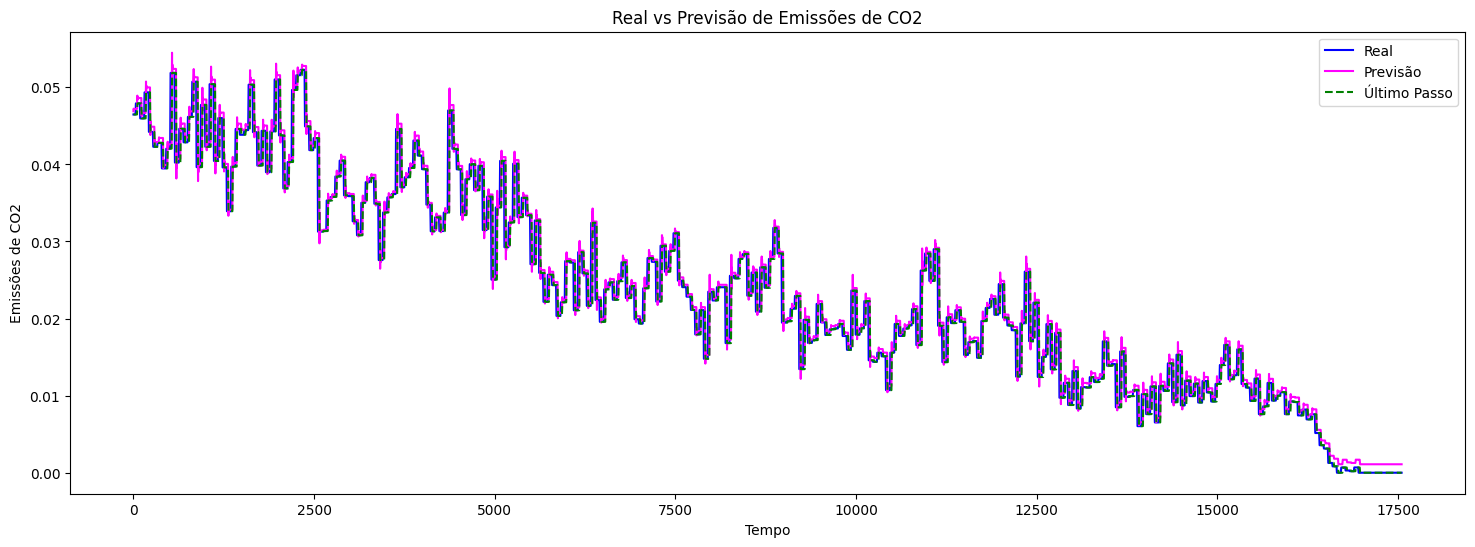

MSE naive: 6.650472471800755e-06, MSE do Modelo: 6.7034771604020726e-06


In [95]:
# Visualizar a predição
SIZE = 17550
plt.figure(figsize=(18, 6))
plt.plot(list(range(SIZE)), y_test[:SIZE], label='Real', color='blue')
plt.plot(y_pred.flatten()[:SIZE], label='Previsão', color='magenta')
plt.plot(X_test[:, -1, 0][:SIZE], label='Último Passo', color = 'green', linestyle='dashed')
plt.legend()
plt.title('Real vs Previsão de Emissões de CO2')
plt.xlabel('Tempo')
plt.ylabel('Emissões de CO2')
#plt.savefig('real_vs_previsao_LSTM_LuST.png')
plt.show()

# Calcular e imprimir os MSEs ingênuo e do modelo
naive_mse = np.square(X_test[:, -1, 0] - y_test).mean()
model_mse = np.square(y_pred.flatten() - y_test).mean()
print(f"MSE naive: {naive_mse}, MSE do Modelo: {model_mse}")

 Visto que, cada iteração do loop sobre train_data.items() cria um novo gráfico para uma RSU específica, onde o modelo LSTM foi treinado e avaliado. 
 Portanto, esse gráfico acima não é uma combinação de todas as RSUs, mas sim uma representação visual das previsões versus valores reais para uma RSU individual.

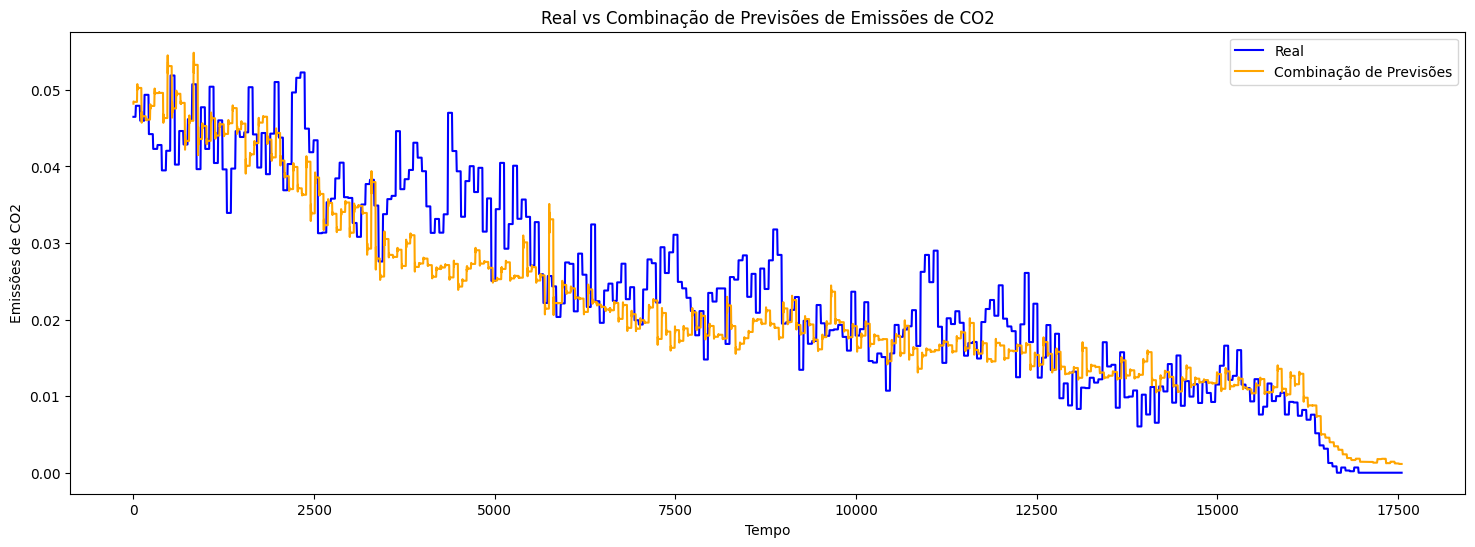

MSE da Combinação: 3.264218580464508e-05


In [96]:
# Calcular a média das previsões de todas as RSUs
combined_predictions = np.zeros_like(y_pred.flatten())
for rsu, (X_test, y_test) in test_data.items():
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    y_pred = model.predict(X_test, verbose=0)
    combined_predictions += y_pred.flatten()

combined_predictions /= len(test_data)  # Média das previsões

# Calcular MSE da combinação
combined_mse = np.square(combined_predictions - y_test).mean()

# Plotar o gráfico combinado
plt.figure(figsize=(18, 6))
plt.plot(list(range(SIZE)), y_test[:SIZE], label='Real', color='blue')
plt.plot(combined_predictions[:SIZE], label='Combinação de Previsões', color='orange')
plt.legend()
plt.title('Real vs Combinação de Previsões de Emissões de CO2')
plt.xlabel('Tempo')
plt.ylabel('Emissões de CO2')
plt.show()

# Imprimir MSE da combinação
print(f"MSE da Combinação: {combined_mse}")


In [ ]:
redictions[:SIZE], label='Combinação de Previsões', color='orange')
plt.legend()
plt.title('Real vs Combinação de Previsões de Emissões de CO2')
plt.xlabel('Tempo')
plt.ylabel('Emissões de CO2')
plt.show()

# Imprimir MSE da combinação
print(f"MSE da Combinação: {combined_mse}")


In [263]:
SIZE

17550

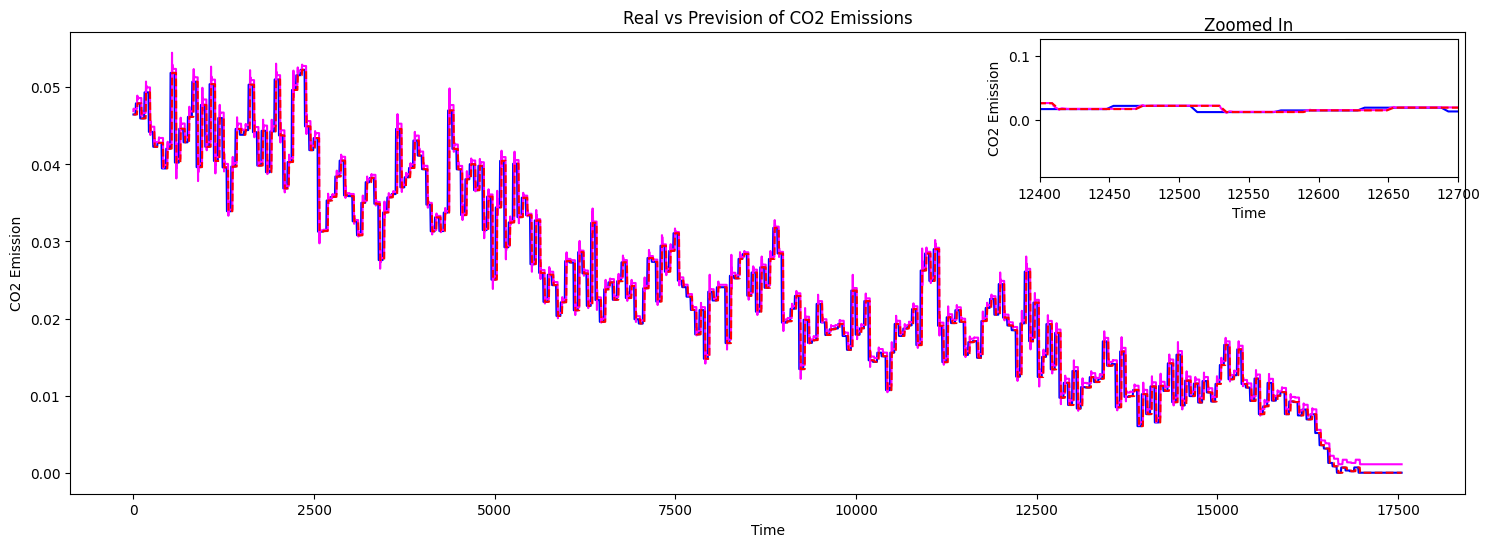

MSE naive: 6.650472471800755e-06, MSE do Modelo: 6.7034771604020726e-06


In [97]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Assume SIZE, y_test, y_pred, and X_test are already defined

# Visualizar a predição
fig, ax = plt.subplots(figsize=(18, 6))
ax.plot(list(range(SIZE)), y_test[:SIZE], label='Real', color='blue')
ax.plot(y_pred.flatten()[:SIZE], label='Prevision', color='magenta')
ax.plot(X_test[:, -1, 0][:SIZE], label='Last Step', color='red', linestyle='dashed')
ax.legend()
ax.set_title('Real vs Prevision of CO2 Emissions')
ax.set_xlabel('Time')
ax.set_ylabel('CO2 Emission')

# Zoomed-in inset
zoom_start = 12400#SIZE//3  # starting index for zoom (example: one third of the way in)
zoom_end = 12700#2*SIZE//3  # ending index for zoom (example: two thirds of the way in)

ax_inset = inset_axes(ax, width="30%", height="30%", loc='upper right')
ax_inset.plot(list(range(SIZE)), y_test[:SIZE], label='Real', color='blue')
ax_inset.plot(y_pred.flatten()[:SIZE], label='Prevision', color='magenta')
ax_inset.plot(X_test[:, -1, 0][:SIZE], label='Last Step', color='red', linestyle='dashed')
ax_inset.set_xlim(zoom_start, zoom_end)
ax_inset.set_ylim(min(y_test[zoom_start:zoom_end].min(), y_pred.flatten()[zoom_start:zoom_end].min()) - 0.1,
                  max(y_test[zoom_start:zoom_end].max(), y_pred.flatten()[zoom_start:zoom_end].max()) + 0.1)
ax_inset.set_title('Zoomed In')
ax_inset.set_xlabel('Time')
ax_inset.set_ylabel('CO2 Emission')

plt.show()
#plt.savefig('real_vs_previsao_LSTM_LuST_h10.png')

# Calcular e imprimir os MSEs ingênuo e do modelo
naive_mse = np.square(X_test[:, -1, 0] - y_test).mean()
model_mse = np.square(y_pred.flatten() - y_test).mean()
print(f"MSE naive: {naive_mse}, MSE do Modelo: {model_mse}")
